In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, precision_recall_curve, multilabel_confusion_matrix

import tensorflow as tf
import keras 

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, InputLayer, Flatten, Conv2D, MaxPooling2D, Concatenate, Input, Average, LocallyConnected2D, BatchNormalization
from keras import layers
#from tensorflow_addons.optimizers import CyclicalLearningRate

np.random.seed(42)
tf.random.set_seed(42)

from getdata import *

In [30]:
d=2
N=0

X_train0, X_test0, y_train0, y_test0 = get_tts(dim=0, N=N, d=d, normalize=True, segmented=False, multiclass=False)
X_train1, X_test1, y_train1, y_test1 = get_tts(dim=1, N=N, d=d, normalize=True, segmented=False, multiclass=False)
X_train2, X_test2, y_train2, y_test2 = get_tts(dim=2, N=N, d=d, normalize=True, segmented=False, multiclass=False)

y_train = y_train2
y_test = y_test2

loading train OASIS 2D-Data


100%|██████████| 209/209 [00:19<00:00, 10.70it/s]


loading train ADNI 2D-Data


100%|██████████| 623/623 [03:23<00:00,  3.06it/s]


loading test OASIS 2D-Data


100%|██████████| 70/70 [00:06<00:00, 10.87it/s]


loading train ADNI 2D-Data


100%|██████████| 208/208 [01:09<00:00,  3.01it/s]


finished loading data
loading train OASIS 2D-Data


100%|██████████| 209/209 [00:19<00:00, 10.98it/s]


loading train ADNI 2D-Data


100%|██████████| 623/623 [03:24<00:00,  3.05it/s]


loading test OASIS 2D-Data


100%|██████████| 70/70 [00:06<00:00, 10.86it/s]


loading train ADNI 2D-Data


100%|██████████| 208/208 [01:09<00:00,  3.01it/s]


finished loading data


In [ ]:
Input0 = Input(shape=X_train0[0].shape, name='input0')
Input1 = Input(shape=X_train1[0].shape, name='input1')
Input2 = Input(shape=X_train2[0].shape, name='input2')



#b_model = Model(b_model.input, b_model.layers[-5].output)

augmentation = keras.Sequential([
layers.Lambda(lambda x: tf.image.random_contrast(x,0.6,1)),
layers.Lambda(lambda x: tf.image.random_brightness(x,0.3)),
#layers.RandomFlip(mode="horizontal"),    
layers.RandomRotation(0.01),
layers.RandomZoom(0.05)
])

def build_model(Input, dim):
  b_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
  for layer in b_model.layers[:-4]:
      layer.trainable=False
  for layer in b_model.layers:
      layer._name = layer.name + str(dim)
  b_model = Model(inputs=b_model.input, outputs = b_model.output)
  x = Input
  x = augmentation(x)
  x = b_model(x)
  #x = LocallyConnected2D(4, 3, 1, activation='relu')(x)
  #x = Conv2D(16,3,1, activation='relu')(x)
  #x = Conv2D(16,3,1, activation='relu')(x)
  #x = MaxPooling2D()(x)
  x = Flatten()(x)
  x = Dense(256, activation='relu')(x)
  #x = Dropout(0.2)(x)
  return x

x = Concatenate()([build_model(Input0, 0), build_model(Input1, 1), build_model(Input2, 2)])
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
out = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[Input0, Input1, Input2], outputs=out)

# Defining optimizer and learning rate
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=1000,
    decay_rate=1,
    staircase=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, name='Adam')
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)

#print(model.summary())

with tf.device('/device:GPU:0'):
  training = model.fit([X_train0, X_train1, X_train2], y_train, epochs=500, shuffle=True, validation_data=([X_test0, X_test1, X_test2], y_test), callbacks=callback)

Epoch 1/500
26/26 [==============================] - 17s 583ms/step - loss: 1.5023 - accuracy: 0.3486 - val_loss: 1.1523 - val_accuracy: 0.4281
Epoch 2/500
26/26 [==============================] - 15s 578ms/step - loss: 1.0845 - accuracy: 0.4279 - val_loss: 1.0546 - val_accuracy: 0.4101
Epoch 3/500
26/26 [==============================] - 15s 570ms/step - loss: 1.0382 - accuracy: 0.4663 - val_loss: 1.0237 - val_accuracy: 0.4928
Epoch 4/500
26/26 [==============================] - 14s 542ms/step - loss: 1.0153 - accuracy: 0.5349 - val_loss: 1.0536 - val_accuracy: 0.3885
Epoch 5/500
26/26 [==============================] - 14s 539ms/step - loss: 1.0162 - accuracy: 0.5216 - val_loss: 0.9808 - val_accuracy: 0.5252
Epoch 6/500
26/26 [==============================] - 14s 540ms/step - loss: 0.9873 - accuracy: 0.5325 - val_loss: 0.9686 - val_accuracy: 0.5396
Epoch 7/500
26/26 [==============================] - 14s 537ms/step - loss: 0.9457 - accuracy: 0.5493 - val_loss: 0.9966 - val_accuracy:

In [52]:
# Defining optimizer and learning rate
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.01,
    decay_steps=100,
    decay_rate=1,
    staircase=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, name='Adam')
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)

#print(model.summary())

with tf.device('/device:GPU:0'):
  training = model.fit([X_train0, X_train1, X_train2], y_train, epochs=500, shuffle=True, validation_data=([X_test0, X_test1, X_test2], y_test), callbacks=callback)

Epoch 1/500
26/26 [==============================] - 17s 565ms/step - loss: 1.1865 - accuracy: 0.4207 - val_loss: 1.0790 - val_accuracy: 0.4281
Epoch 2/500
26/26 [==============================] - 15s 572ms/step - loss: 1.0743 - accuracy: 0.3966 - val_loss: 1.0591 - val_accuracy: 0.4281
Epoch 3/500
26/26 [==============================] - 15s 569ms/step - loss: 1.0655 - accuracy: 0.4279 - val_loss: 1.0580 - val_accuracy: 0.4281
Epoch 4/500
26/26 [==============================] - 14s 545ms/step - loss: 1.0617 - accuracy: 0.4279 - val_loss: 1.0587 - val_accuracy: 0.4281
Epoch 5/500
26/26 [==============================] - 14s 542ms/step - loss: 1.0602 - accuracy: 0.4279 - val_loss: 1.0563 - val_accuracy: 0.4281
Epoch 6/500
26/26 [==============================] - 14s 535ms/step - loss: 1.0597 - accuracy: 0.4279 - val_loss: 1.0563 - val_accuracy: 0.4281
Epoch 7/500
26/26 [==============================] - 14s 537ms/step - loss: 1.0590 - accuracy: 0.4279 - val_loss: 1.0569 - val_accuracy:

KeyboardInterrupt: ignored

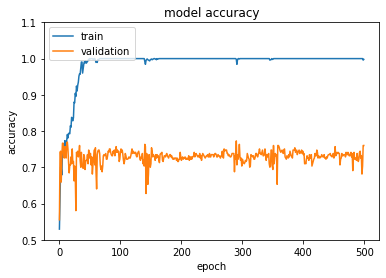

In [65]:
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.ylim([0.5,1.1])
plt.show()

accuracy:  0.77
recall:  0.89
precision:  0.74


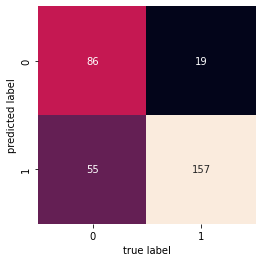

In [57]:
y_predd = model.predict(X_test)#([X_test0, X_test1, X_test2])
y_pred = (y_predd>0.5).astype(int)

# Plotting the confusing matrix
mat = confusion_matrix(y_test, y_pred.round())
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
print('accuracy: ' , accuracy_score(y_test, y_pred.round()).round(2))
print('recall: ' , recall_score(y_test, y_pred.round()).round(2))
print('precision: ' , precision_score(y_test, y_pred.round()).round(2))

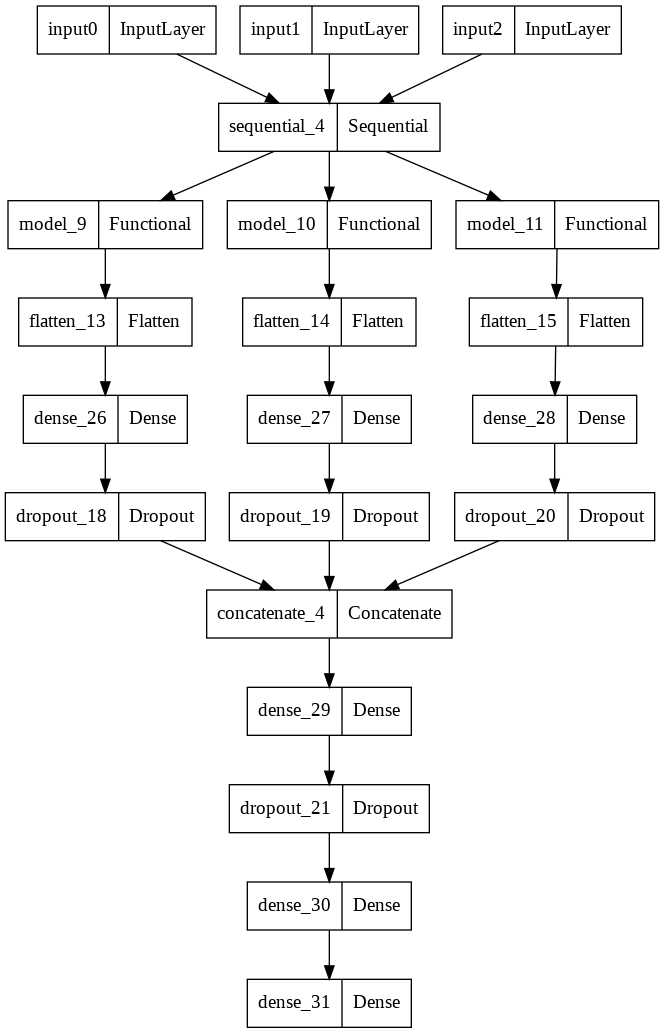

In [49]:
tf.keras.utils.plot_model(model)